# Risk Sentiment - Interest Rates

## Imports

In [55]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import pmp_functions_v5 as pmp
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

path = "../../Data_Ryan"

## Global Variables

In [56]:
frequency = 1
t_cost = 0
target_vol = 0.1
min_regions = 4
lag = 1

## Data

### Riskfree Data

In [57]:
# --- Load Riskfree Rate ---
factors_data = pd.read_excel(
    f"{path}/Factors.xlsx",
    index_col = 0,
    parse_dates = True
)

factors_data.index = pd.to_datetime(factors_data.index, format='%Y%m')
factors_data.index = factors_data.index + pd.offsets.MonthEnd(0)
factors_data /= 100

riskfree = factors_data["RF"].resample('ME').last()
display(riskfree)

/var/folders/bl/ywj9s7j57_qf7pwls_sv_w9r0000gn/T/ipykernel_28121/711168680.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  factors_data = pd.read_excel(


1926-07-31    0.0022
1926-08-31    0.0025
1926-09-30    0.0023
1926-10-31    0.0032
1926-11-30    0.0031
               ...  
2025-06-30    0.0034
2025-07-31    0.0034
2025-08-31    0.0038
2025-09-30    0.0033
2025-10-31    0.0037
Freq: ME, Name: RF, Length: 1192, dtype: float64

### Factor Data

In [58]:
# --- Load Factors Data ---
famafrench_data = pd.read_csv(
    f"{path}/famafrench_factors.csv",
    index_col = 0,
    parse_dates = True
)

famafrench_data.index = pd.to_datetime(famafrench_data.index, format='%Y%m')
famafrench_data.index = famafrench_data.index + pd.offsets.MonthEnd(0)
display(famafrench_data)

/var/folders/bl/ywj9s7j57_qf7pwls_sv_w9r0000gn/T/ipykernel_28121/3509264678.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  famafrench_data = pd.read_csv(


,MKT-RF,SMB,HML,RMW,CMA,UMD,BAB
DATE,,,,,,,
1980-01-31,0.0550,0.0188,0.0185,-0.0184,0.0189,0.0745,0.0695
1980-02-29,-0.0123,-0.0162,0.0059,-0.0095,0.0292,0.0789,-0.0132
1980-03-31,-0.1289,-0.0697,-0.0096,0.0182,-0.0105,-0.0958,-0.1181
1980-04-30,0.0396,0.0105,0.0103,-0.0218,0.0034,-0.0048,0.0574
1980-05-31,0.0526,0.0200,0.0038,0.0043,-0.0063,-0.0118,0.0618
...,...,...,...,...,...,...,...
2025-06-30,0.0486,-0.0002,-0.0160,-0.0320,0.0145,-0.0264,0.0527
2025-07-31,0.0198,-0.0015,-0.0127,-0.0029,-0.0208,-0.0096,0.0184
2025-08-31,0.0185,0.0488,0.0442,-0.0068,0.0207,-0.0354,0.0646


### Benchmark Data

In [59]:
# --- Benchmark Data ---
benchmark_data = pd.read_excel(
    f"{path}/Benchmarks.xlsx",
    index_col = 0,
    parse_dates = True
)

benchmark_data.index = pd.to_datetime(benchmark_data.index)
benchmark_data = benchmark_data.resample('ME').last()
display(benchmark_data)

benchmark_TR = benchmark_data[['60/40']].pct_change()
benchmark_XR = benchmark_TR.sub(riskfree, axis = 0)

benchmark_TR.columns = ['Benchmark Total Return']
benchmark_XR.columns = ['Benchmark Excess Return']
benchmark_returns = pd.concat([benchmark_TR, benchmark_XR], axis = 1).dropna()

display(benchmark_returns)

benchmark_TR = benchmark_TR.squeeze()

,S&P 500,MSCI World,FTSE WGBI,60/40
Date,,,,
1986-12-31,242.1700,NaN,156.5737,14.640989
1987-01-31,274.7800,NaN,161.2733,15.080442
1987-02-28,285.6377,NaN,163.7959,15.316327
1987-03-31,293.8792,NaN,167.5858,15.670715
1987-04-30,291.2698,NaN,169.5120,15.850831
...,...,...,...,...
2025-07-31,14412.5527,8214.1572,899.0753,418.585408
2025-08-31,14704.7217,8431.0801,911.3233,428.564691
2025-09-30,15240.0381,8705.7139,916.8774,440.268260


,Benchmark Total Return,Benchmark Excess Return
1987-01-31,0.030015,0.025815
1987-02-28,0.015642,0.011342
1987-03-31,0.023138,0.018438
1987-04-30,0.011494,0.007094
1987-05-31,-0.009907,-0.013707
...,...,...
2025-06-30,0.038273,0.034873
2025-07-31,0.006737,0.003337
2025-08-31,0.023840,0.020040
2025-09-30,0.027309,0.024009


### Equity Data

In [60]:
# --- Load Equity Price Data ---
equity_prices = pd.read_excel(
    f"{path}/Equity Data.xlsx",
    index_col = 0,
    parse_dates = True
)
equity_prices.index = pd.to_datetime(equity_prices.index)
equity_prices.index = equity_prices.index + pd.offsets.MonthEnd(0)

display(equity_prices)

,US,AU,CH,JP,UK,EM,EU
Date,,,,,,,
1997-09-30,1206.821289,NaN,NaN,7.33429,7487.55371,NaN,NaN
1997-10-31,1168.258667,NaN,NaN,6.82642,7084.46436,NaN,NaN
1997-11-30,1207.453491,NaN,NaN,6.34016,7152.55615,NaN,NaN
1997-12-31,1223.840210,NaN,NaN,5.86087,7365.37451,NaN,NaN
1998-01-31,1234.778442,NaN,NaN,6.36481,7690.75049,NaN,NaN
...,...,...,...,...,...,...,...
2025-06-30,6308.888672,5641.31592,14994.83984,19.64406,12121.12598,14955.800000,6276.48438
2025-07-31,6430.451172,5627.64307,14552.98438,19.41757,12131.93066,15094.600000,6109.94238
2025-08-31,6529.819336,5881.38037,15274.74121,20.75129,12521.77637,15223.700000,6284.96094


### Interest Rate Data

In [61]:
# --- Load Interest Rate Futures ---
interest_futures = pd.read_excel(
    f"{path}/Interest Rates Data.xlsx",
    index_col = 0,
    parse_dates = True
)
interest_futures.index = pd.to_datetime(interest_futures.index)
interest_futures.index = interest_futures.index + pd.offsets.MonthEnd(0)

display("Interest Rate Futures:")
display(interest_futures)

'Interest Rate Futures:'

,CH,EU,AU,US,EM,UK,JP
Date,,,,,,,
1998-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-02-28,94.564,NaN,97.169,95.44,77.41,NaN,98.3323
1998-03-31,94.334,NaN,97.251,95.49,78.42,NaN,98.4613
1998-04-30,94.286,NaN,97.180,95.47,79.49,NaN,98.4910
1998-05-31,94.286,NaN,97.221,95.40,78.30,NaN,98.5456
...,...,...,...,...,...,...,...
2025-07-31,100.732,98.015,96.680,99.27,97.94,97.65,99.4600
2025-08-31,100.732,97.970,96.660,99.27,96.99,97.38,99.4600
2025-09-30,100.732,97.975,96.490,99.27,96.60,97.26,99.4600


In [62]:
# --- Interest Rate Returns ---
interest_XR = interest_futures.pct_change()
interest_XR = interest_XR.resample('ME').last()

display(interest_XR)

,CH,EU,AU,US,EM,UK,JP
Date,,,,,,,
1998-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-03-31,-0.002432,NaN,0.000844,0.000524,0.013047,NaN,0.001312
1998-04-30,-0.000509,NaN,-0.000730,-0.000209,0.013644,NaN,0.000302
1998-05-31,0.000000,NaN,0.000422,-0.000733,-0.014970,NaN,0.000554
...,...,...,...,...,...,...,...
2025-07-31,0.000000,-0.001019,-0.002281,0.000000,0.000000,-0.001840,0.000000
2025-08-31,0.000000,-0.000459,-0.000207,0.000000,-0.009700,-0.002765,0.000000
2025-09-30,0.000000,0.000051,-0.001759,0.000000,-0.004021,-0.001232,0.000000


## Signal Generation

In [63]:
# --- Compute Risk Sentiment Signal ---
risk_sentiment_signal = equity_prices.pct_change(12).resample('ME').last()

display('Risk Sentiment Signal:')
display(risk_sentiment_signal)

'Risk Sentiment Signal:'

,US,AU,CH,JP,UK,EM,EU
Date,,,,,,,
1997-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-06-30,0.089128,0.068200,0.135337,0.154598,0.144851,0.289415,0.182202
2025-07-31,0.102824,0.049903,0.052154,0.073431,0.108819,0.101297,0.147454
2025-08-31,0.099490,0.061966,0.057742,0.147609,0.115843,0.169668,0.137625


In [64]:
# --- Composite Signal Construction ---
# Logic: For Interest Rates, we want decreasing Risk Sentiment (-)
risk_sentiment_signal = - risk_sentiment_signal

display("Risk Sentiment Signal:")
display(risk_sentiment_signal)

'Risk Sentiment Signal:'

,US,AU,CH,JP,UK,EM,EU
Date,,,,,,,
1997-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-06-30,-0.089128,-0.068200,-0.135337,-0.154598,-0.144851,-0.289415,-0.182202
2025-07-31,-0.102824,-0.049903,-0.052154,-0.073431,-0.108819,-0.101297,-0.147454
2025-08-31,-0.099490,-0.061966,-0.057742,-0.147609,-0.115843,-0.169668,-0.137625


## Portfolio Construction

In [65]:
# --- Compute Weights ---
weights, scaling_factors, weights_raw = pmp.make_country_weights_ls_vol(
    signal=risk_sentiment_signal,
    returns= interest_XR,
    min_regions=min_regions,
    signal_lag= lag,
    vol_target=target_vol,
    vol_lookback=24
)
# weights = weights.clip(lower=-2.0, upper=2.0)
weights

,US,AU,CH,JP,UK,EM,EU
2002-01-31,-7.281216,-11.831975,1.820304,10.921824,NaN,NaN,6.371064
2002-02-28,-7.269330,-11.812661,1.817332,10.903995,NaN,NaN,6.360664
2002-03-31,-6.497967,-10.559196,1.624492,9.746950,NaN,NaN,5.685721
2002-04-30,-5.348206,-9.168353,-1.528059,9.932382,NaN,NaN,6.112235
2002-05-31,1.530516,-9.948357,-6.122066,9.183099,NaN,NaN,5.356808
...,...,...,...,...,...,...,...
2025-06-30,3.134710,4.702065,-3.134710,-1.567355,1.567355,-4.702065,0.000000
2025-07-31,3.315535,4.973302,1.657767,-1.657767,0.000000,-4.973302,-3.315535
2025-08-31,-1.625386,4.876159,3.250772,1.625386,-3.250772,0.000000,-4.876159
2025-09-30,1.633574,3.267149,4.900723,-3.267149,0.000000,-4.900723,-1.633574


## Backtest

In [66]:
results = pmp.run_cc_strategy(
    weights = weights,
    returns = interest_XR,
    rf = riskfree,
    frequency=1,
    t_cost= t_cost,
    benchmark = benchmark_TR
)

display(results)

results.to_csv('macroRS_rates.csv')

,ret_net,ret_gross,ret_bm,turnover,tcost,ret_rf,w_US,w_AU,w_CH,w_JP,w_UK,w_EM,w_EU
Date,,,,,,,,,,,,,
2002-02-28,-0.009535,-0.009535,-0.002021,0.000000,0.0,0.0013,-7.281960,-11.836917,1.820133,10.919093,0.000000,0.000000,6.370116
2002-03-31,0.073173,0.073173,0.022050,0.032119,0.0,0.0013,-7.261160,-11.748308,1.821952,10.905633,0.000000,0.000000,6.355056
2002-04-30,-0.050586,-0.050586,-0.001331,1.988891,0.0,0.0015,-6.527878,-10.594765,1.627645,9.748414,0.000000,0.000000,5.695997
2002-05-31,0.018399,0.018399,0.014872,3.180997,0.0,0.0014,-5.349839,-9.141409,-1.533024,9.933874,0.000000,0.000000,6.108797
2002-06-30,-0.027651,-0.027651,-0.007289,6.889555,0.0,0.0013,1.531919,-9.979920,-6.130137,9.183099,0.000000,0.000000,5.367387
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30,0.020617,0.020617,0.038273,6.261908,0.0,0.0034,3.142837,4.717176,-4.714255,0.000000,1.580953,-3.134835,-1.571258
2025-07-31,-0.013608,-0.013608,0.006737,3.161112,0.0,0.0034,3.134710,4.691341,-3.134710,-1.567355,1.564471,-4.702065,0.000000
2025-08-31,0.048734,0.048734,0.023840,5.248458,0.0,0.0038,3.315535,4.972273,1.657767,-1.657767,0.000000,-4.925062,-3.314012


# Performance Statistics

In [67]:
pmp.run_perf_summary_benchmark_vs_strategy(results, alreadyXs = True)

,Benchmark,Strategy
Arithm Avg Total Return,7.4704,1.1335
Arithm Avg Xs Return,5.8687,-0.4682
Std Xs Returns,9.7198,14.1220
Sharpe Arithmetic,0.6038,-0.0332
Geom Avg Total Return,7.2245,0.1207
Geom Avg Xs Return,5.6124,-1.4914
Sharpe Geometric,0.5774,-0.1056
Min Xs Return,-10.2114,-26.2830
Max Xs Return,8.6715,22.9503
Skewness,-0.4979,-0.2151


## Plots

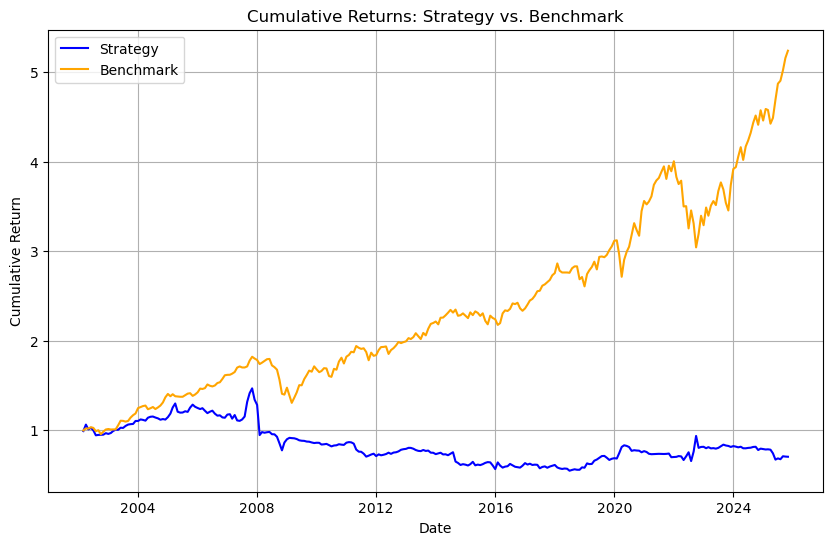

In [68]:
plt.figure(figsize=(10, 6))
plt.plot((1 + results["ret_net"]).cumprod(), label="Strategy", color="blue")
plt.plot((1 + results["ret_bm"]).cumprod(), label="Benchmark", color="orange")
plt.title("Cumulative Returns: Strategy vs. Benchmark")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
#make the y-axis logarithmic
#plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()